# Feature extraction and Time Series Forecasting in kdb+

The purpose of this notebook is to demonstrate the use of feature extraction in kdb+ as a method for to aid in the forecasting of features within our dataset given historical information about the system

### Loading Library Scripts and Data

In the following cell the functions related to the FreshQ library are loaded in the 1st line while preprocessing functions used within the notebook are loaded from the folder mlutils

In [1]:
\l ml/init.q
\c 15 100

~


Load in a dataset containing the daily Open/Low/High/Close prices and Volume of trades for Amazon Stock from 1997-2017

In [2]:
5#amzndaydata:{lower[cols x]xcol x}("DFFFFJJ";enlist ",")0:`:SampleDatasets/amzn_day.us.txt
-1!"This dataset contains stock information for ",(string count amzndaydata)," days."
5#amzndaydata:.ml.dropconstant[amzndaydata]

date       open high low  close volume   openint
------------------------------------------------
1997.05.16 1.97 1.98 1.71 1.73  14700000 0      
1997.05.19 1.76 1.77 1.62 1.71  6106800  0      
1997.05.20 1.73 1.75 1.64 1.64  5467200  0      
1997.05.21 1.64 1.65 1.38 1.43  18853200 0      
1997.05.22 1.44 1.45 1.31 1.4   11776800 0      


"This dataset contains stock information for 5170 days."


date       open high low  close volume  
----------------------------------------
1997.05.16 1.97 1.98 1.71 1.73  14700000
1997.05.19 1.76 1.77 1.62 1.71  6106800 
1997.05.20 1.73 1.75 1.64 1.64  5467200 
1997.05.21 1.64 1.65 1.38 1.43  18853200
1997.05.22 1.44 1.45 1.31 1.4   11776800


## Produce a forecasting frame from the dataset

Create an artificial forecasting frame through the production of rolling windows across the data. Polynomial features have also been added to the data to augment the number of features being calculated and to include potentially important information which can be garnered from the behaviour of combined features.

In [3]:
table:amzndaydata^.ml.polytab[amzndaydata;2;1]
show tabinit:.ml.tablerolldrop[table;`date;10]
-1"The forecasting frame contains ",(string count tabinit)," datapoints.";

date        open high low  close volume   open_high open_low open_close open_volume  high_low hig..
-------------------------------------------------------------------------------------------------..
t1997.05.30 1.97 1.98 1.71 1.73  14700000 3.9006    3.3687   3.4081     2.8959e+07   3.3858   3.4..
t1997.05.30 1.76 1.77 1.62 1.71  6106800  3.1152    2.8512   3.0096     1.074797e+07 2.8674   3.0..
t1997.05.30 1.73 1.75 1.64 1.64  5467200  3.0275    2.8372   2.8372     9458256      2.87     2.8..
t1997.05.30 1.64 1.65 1.38 1.43  18853200 2.706     2.2632   2.3452     3.091925e+07 2.277    2.3..
t1997.05.30 1.44 1.45 1.31 1.4   11776800 2.088     1.8864   2.016      1.695859e+07 1.8995   2.0..
t1997.05.30 1.41 1.52 1.33 1.5   15937200 2.1432    1.8753   2.115      2.247145e+07 2.0216   2.2..
t1997.05.30 1.51 1.65 1.46 1.58  8697600  2.4915    2.2046   2.3858     1.313338e+07 2.409    2.6..
t1997.05.30 1.62 1.64 1.53 1.53  4574400  2.6568    2.4786   2.4786     7410528      2.5092   2.5..


## Set the target values for forecasting

In this case we are attempting to use the forecasting frames to predict the close price for the next following day given extracted features from the previous 5 days.

In [4]:
tabletargets:10 _amzndaydata
targets:tabletargets[`close]

In [5]:
count targets

5160


## Assign extracted features and complete extraction

In [6]:
/ in this example we look only at features of the data alone with no parameters
show singleinputfeatures:.fresh.getsingleinputfeatures[]

\t tabraw:.fresh.createfeatures[tabinit;`date;1_ cols tabinit;singleinputfeatures]
show tabraw
-1"The number of rows in the data is: ",string count tabraw;

absenergy     | {x wsum x}
abssumchange  | {sum abs 1_deltas x}
count         | {count x}
countabovemean| {sum x>avg x}
countbelowmean| {sum x<avg x}
firstmax      | {(x?max x)%count x}
firstmin      | {(x?min x)%count x}
hasdup        | {count[x]<>count distinct x}
hasdupmax     | {1<sum x=max x}
hasdupmin     | {1<sum x=min x}
kurtosis      | {((n-1)%(n-2)*n-3)*((n+1)*n*sum[k2*k2]%s*s:sum k2:k*k:x-avg x)+3*1-n:count x}
lastmax       | {(last where x=max x)%count x}
..


7546


date       | absenergy_open absenergy_high absenergy_low absenergy_close absenergy_volume absener..
-----------| ------------------------------------------------------------------------------------..
t1997.05.30| 26.2488        27.315         22.4808       24.2289         1.146768e+15     74.3812..
t1997.06.02| 24.648         25.7355        21.8067       23.5161         9.310284e+14     64.5040..
t1997.06.03| 23.8913        24.9435        21.3727       22.7824         8.951354e+14     60.2794..
t1997.06.04| 23.0888        24.1011        20.6431       22.1092         8.74734e+14      55.9765..
t1997.06.05| 22.4156        23.7502        20.6431       22.4359         5.514669e+14     53.4362..
t1997.06.06| 22.6524        24.5718        21.2071       23.2315         4.737263e+14     55.8323..
t1997.06.09| 23.4199        25.1855        22.1938       23.8376         2.252638e+14     59.2966..
t1997.06.10| 24.0639        25.3871        22.4031       23.8376         1.794141e+14     61.6394..


In [7]:
tabreduced:key[tabraw]!.fresh.significantfeatures[value tabraw;targets]
-1 "The number of columns in the initial dataset is: ",string count cols tabinit;
-1 "The number of columns in the unfiltered dataset is: ",string count cols tabraw;
-1 "The number of columns in the filtered dataset is: ",string count cols tabreduced;

The number of columns in the initial dataset is: 16
The number of columns in the unfiltered dataset is: 541
The number of columns in the filtered dataset is: 321


## Convert Data

The data must now be converted to a matrix from a table in order to allow it to be passed to a machine learning algorithm for training.

In the below cell, I have reintroduced the original data for each day into the dataset such that it now contains both the original and derived datapoints

In [8]:
rawdata:-1 _9 _amzndaydata
datamat:{0^flip value flip x}

fitvalsfilter:datamat rawdata,'value tabreduced
fitvalsraw:datamat rawdata,'value tabraw
newpredictor:datamat delete date from rawdata

---

## Training the Model

Here we train our model using a gradient boost regressor to estimate the close price. The application of forms of regression on financial data is can be quite tempermental with high dependency on how the data is split influencing the final result achieved.

In the definition of the gradient boosting regressor below the addition of``` `verbose pykw 1``` allows for the training times and training loss as a function of iterations to be displayed

In [9]:
k:rand 1000
reg:.p.import[`sklearn.ensemble][`:GradientBoostingRegressor][`learning_rate pykw 0.1;`n_estimators pykw 200;`random_state pykw k]

### Fit data to the models and make predictions

In the below example:

* dict1 = input only the initial time series data
* dict2 = unfiltered data input.
* dict3 = filtered data input.

In [10]:
seed:rand 1000

dict1:.ml.traintestsplitseed[newpredictor;targets;0.2;seed];
dict2:.ml.traintestsplitseed[fitvalsraw;targets;0.2;seed];
dict3:.ml.traintestsplitseed[fitvalsfilter;targets;0.2;seed];

reg[`:fit][dict1[`xtrain];dict1[`ytrain]]`;
pred1:reg[`:predict][dict1[`xtest]]`

reg[`:fit][dict2[`xtrain];dict2[`ytrain]]`;
pred2:reg[`:predict][dict2[`xtest]]`

reg[`:fit][dict3[`xtrain];dict3[`ytrain]]`;
pred3:reg[`:predict][dict3[`xtest]]`


## Results

Below the mean squared error is calculated between the predicted values of for the next day close price and the actual value, this is a reasonable proxy for the accuracy of the model. The benchmark which we compare the model to is that yesterdays close price is the best indicator of what todays close will be.

In [11]:
mse:{(sum k*k:x-y)%count x}
-1 "The mean square error(mse) between the test and prediction from the untreated data is: ",string mse[dict1[`ytest];pred1];
-1 "The mse between the test and predicted data without filtering is: ",string mse[dict2[`ytest];pred2];
-1 "The mse between the test and predicted data with filtering is: ",string mse[dict3[`ytest];pred3];
-1 "The mse between the current and previous day would be: ",string mse . 1 -1_\:amzndaydata[`close];

The mean square error(mse) between the test and prediction from the untreated data is: 32.78208
The mse between the test and predicted data without filtering is: 30.26359
The mse between the test and predicted data with filtering is: 29.22653
The mse between the current and previous day would be: 28.48191


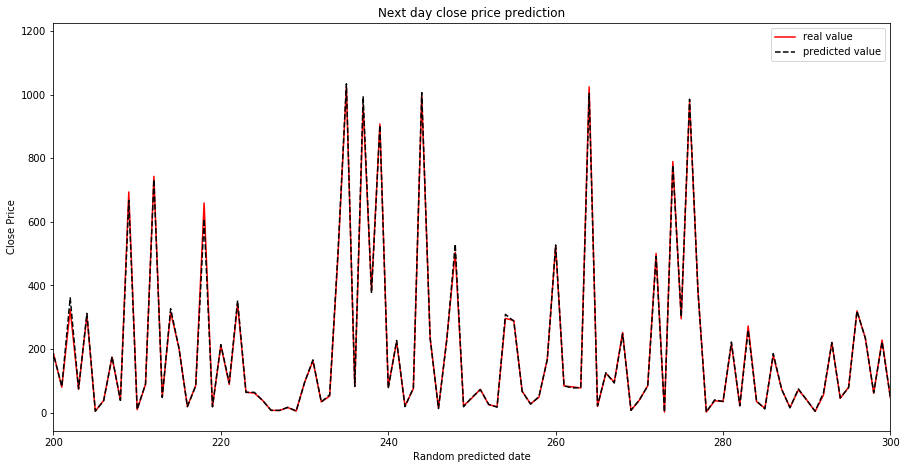

In [12]:
plt:.p.import[`matplotlib]`:pyplot

plt[`:close][]`;
plt[`:figure][`figsize pykw (15 7.5)]`;
plt[`:title][`$"Next day close price prediction"];
plt[`:plot][dict2[`ytest];"r";`label pykw `$"real value"]`;
plt[`:plot][pred2;"k--";`label pykw `$"predicted value"]`;
plt[`:legend][]`;
plt[`:xlim][200;300]`;
plt[`:xlabel]["Random predicted date"];
plt[`:ylabel]["Close Price"];
plt[`:show][]`;


## Conclusions

Multiple runs of the above fit and results sections give an indication both of the usefulness of this form of analysis and the difficultly which is posed in the prediction of stock information. 

In the majority of cases it is seen that the mean squared error decreases in the order 

1. Untreated Data
2. Extracted Features without significance testing
3. Extracted Features with significance testing
4. Yesterday's price = Today's price

However depending on how the data is split by the traintestsplit function large variations in the the mean squared error can occur. This relates to the inclusion or omission of specific events which would cause large errors in prediction such as issues with the global economy or issues with staff. It can also have a detrimental effect on the order which is seen above with variations in this order possible if the features extracted from the split data are not truely indicative of the behaviour of the system.

---